## Homework 6: Backpropagation

Augusto Gonzalez Bonorino



In [ ]:
!apt-get update
!apt-get install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super
!apt-get install poppler-utils

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 229 kB in 1s (169 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version 

In [ ]:
tikz_code = r"""
\documentclass{standalone}
\usepackage{tikz}
\usetikzlibrary{positioning, arrows.meta}
\begin{document}
\begin{tikzpicture}[
    node distance=2cm and 1.2cm,
    mynode/.style={draw, rectangle, align=center, minimum height=1cm, minimum width=2cm},
    mymathnode/.style={draw, rectangle, align=center, minimum height=1cm, minimum width=2.5cm},
    myarrow/.style={-Stealth},
    mylabel/.style={font=\scriptsize\sffamily},
    every node/.style={font=\sffamily},
    thick
]
% Nodes
\node[mynode] (x) {$X$};
\node[mymathnode, right=of x] (f1) {$\sum |f_1$};
\node[mymathnode, right=of f1] (f2) {$\sum |f_2$};
\node[mynode, right=of f2] (yhat) {$\hat{y}$};
\node[mynode, above right=of yhat] (y) {$y$};
\node[mynode, right=of yhat] (loss) {Loss};

% Arrows
\draw[myarrow] (x) -- node[mylabel,above] {$W_1, b_1$} (f1);
\draw[myarrow] (f1) -- node[mylabel,above] {$W_2, b_2$} (f2);
\draw[myarrow] (f2) -- node[mylabel,above] {$W_3, b_3$} (yhat);
\draw[myarrow] (yhat) -- (loss);
\draw[myarrow] (y) -- (loss);

% Labels
\node[mylabel, below=0.5cm of f1] (relu1) {ReLU};
\node[mylabel, below=0.5cm of f2] (relu2) {ReLU};
\node[mylabel, below=0.5cm of yhat] (linear) {Linear};
\end{tikzpicture}
\end{document}
"""

with open('diagram.tex', 'w') as f:
    f.write(tikz_code)


In [ ]:
!pdflatex diagram.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./diagram.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/standalone/standalone.cls
Document Class: standalone 2018/03/26 v1.3a Class to compile TeX sub-files stan
dalone
(/usr/share/texlive/texmf-dist/tex/latex/tools/shellesc.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifluatex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/xkeyval/xkeyval.sty
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkeyval.tex
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/xkvutils.tex
(/usr/share/texlive/texmf-dist/tex/generic/xkeyval/keyval.tex))))
(/usr/share/texlive/texmf-dist/tex/latex/standalone/standalone.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n S

In [ ]:
!pdftoppm diagram.pdf diagram -png -singlefile

## Exercise 1: Draw a neural network with 1 input layer, 2 hidden layers, and 1 output layer.

Here $x \in \mathbb{R}, W_1 \in \mathbb{R}^{5x1}, b_1 \in \mathbb{R}^{5x1}, f_1 = ReLU(x)$ and the sum symbol represents the linear combination (pre-activation values) performed at each layer prior to applying the nonlinear activation function.

Then, for the second layer we have $W_2 \in \mathbb{R}^{3x5}, b_2 \in \mathbb{R}^{3x1}, f_2 = ReLU(a_{i-1})$, where $a_{i-1}$ is the output from the previous layer.

Finally, the output layer has a linear activation function that returns the prediction $\hat{y} \\in \mathbb{R}$ by projecting the linear combination to a one-dimensional space. Here we have $W_3 \in \mathbb{R}^{1x3}, b_3 \in \mathbb{R}^{1x1}, f_3 = Linear(a_{i-1})$.

The performance of the neural network is evaluated with the squared loss function $(y - \hat{y})^2$.

I liked this way of representing it because it makes very clear that, in this fully connected NN, all weights are first linearly combined before being activated. Also, it is clear that the bias is a term shared by all neurons in that layer. It is fairly straightforward to map backpropagation using a similar diagram, starting from Loss move backwards by applying the chain rule at each layer to compute the loss with respect to the predictions.

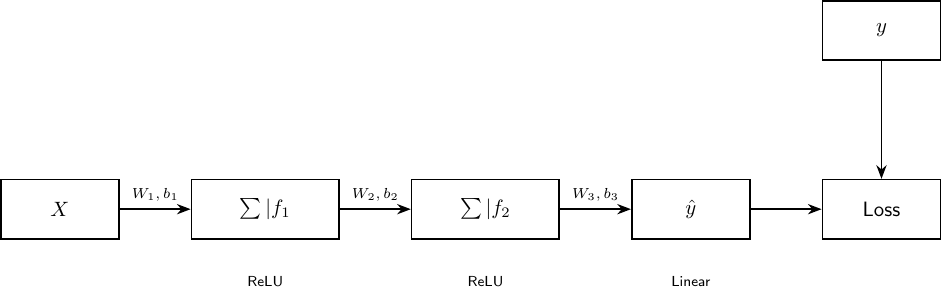

In [ ]:
from IPython.display import Image
Image('diagram.png')

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Gradient descent optimization
# The learning rate is specified by eta
class GDOptimizer(object):
    def __init__(self, eta):
        self.eta = eta

    def initialize(self, layers):
        pass

    # This function performs one gradient descent step
    # layers is a list of dense layers in the network
    # g is a list of gradients going into each layer before the nonlinear activation
    # a is a list of the activations of each node in the previous layer going
    #
    def update(self, layers, g, a):
        m = a[0].shape[1]
        for layer, curGrad, curA in zip(layers, g, a):
            # TODO: PART F #########################################################################
            # Compute the gradients for layer.W and layer.b using the gradient for the output of the
            # layer curA and the gradient of the output curGrad
            # Use the gradients to update the weight and the bias for the layer
            #
            # Normalize the learning rate by m (defined above), the number of training examples input
            # (in parallel) to the network.
            #
            # It may help to think about how you would calculate the update if we input just one
            # training example at a time; then compute a mean over these individual update values.

            # gradient of the cost with respect to the weights, normalized by the number of examples.
            #print("curGrad shape:", curGrad.shape)
            #print("curA shape:", curA.shape)

            dW = (1/m) * np.dot(curGrad, curA.T)
            #print(f"dW {dW.shape}")

            db = (1/m) * np.sum(curGrad, axis=1).reshape(-1,1)
            #print(f"db {db.shape}")

            layer.updateWeights(-self.eta * dW)
            layer.updateBias(-self.eta * db)

            # ######################################################################################
            pass



In [ ]:
# Cost function used to compute prediction errors
class QuadraticCost(object):

    # Compute the squared error between the prediction yp and the observation y
    # This method should compute the cost per element such that the output is the
    # same shape as y and yp
    @staticmethod
    def fx(y,yp):
        # TODO: PART B #########################################################################
        """
        Squared error between prediction yp and observation y.
        Output should be of same shape as y and yp.
        """

        return 0.5 * (np.array(y) - np.array(yp)) ** 2
        # ######################################################################################


    # Derivative of the cost function with respect to yp
    @staticmethod
    def dx(y,yp):
        # TODO: PART B #########################################################################
        """
        Derivative of cost function with respect to yp.
        """

        return np.array(yp) - np.array(y)
        # ######################################################################################

In [ ]:
# Sigmoid function fully implemented as an example
class SigmoidActivation(object):
    @staticmethod
    def fx(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def dx(z):
        return SigmoidActivation.fx(z) * (1 - SigmoidActivation.fx(z))

# Hyperbolic tangent function
class TanhActivation(object):

    # Compute tanh for each element in the input z
    @staticmethod
    def fx(z):
        # TODO: PART C #################################################################################
        return np.tanh(z)
        # ######################################################################################


    # Compute the derivative of the tanh function with respect to z
    @staticmethod
    def dx(z):
        # TODO: PART C #########################################################################
        return 1.-np.tanh(z)**2
        # ######################################################################################

# Rectified linear unit
class ReLUActivation(object):
    @staticmethod
    def fx(z):
        # TODO: PART C #########################################################################
        return np.maximum(0.0, np.array(z))
        # ######################################################################################


    @staticmethod
    def dx(z):
        # TODO: PART C #########################################################################
        ## the easiest way to go about it is to mask the values greater than 0 to create a boolean vector
        ## converting the boolean vector to float gives 1 when z is greater than 0 and 0 otherwise
        return (np.array(z) > 0).astype(float)
        # ######################################################################################


# Linear activation
class LinearActivation(object):
    @staticmethod
    def fx(z):
        # TODO: PART C #########################################################################
        return np.array(z)
        # ######################################################################################


    @staticmethod
    def dx(z):
        # TODO: PART C #########################################################################
        return 1
        # ######################################################################################

        # This class represents a single hidden or output layer in the neural network

In [ ]:
class DenseLayer(object):

    # numNodes: number of hidden units in the layer
    # activation: the activation function to use in this layer
    def __init__(self, numNodes, activation):
        self.numNodes = numNodes
        self.activation = activation

    def getNumNodes(self):
        return self.numNodes

    # Initialize the weight matrix of this layer based on the size of the matrix W
    def initialize(self, fanIn, scale=1.0):
        s = scale * np.sqrt(6.0 / (self.numNodes + fanIn))
        self.W = np.random.normal(0, s,
                                   (self.numNodes, fanIn))
        self.b = np.random.uniform(-1, 1, (self.numNodes, 1))

    # Apply the activation function of the layer on the input z
    def a(self, z):
        return self.activation.fx(z)

    # Compute the linear part of the layer
    # The input a is an n x k matrix where n is the number of samples
    # and k is the dimension of the previous layer (or the input to the network)
    def z(self, a):
        #print("W shape:", self.W.shape)
        #print("a shape:", a.shape)
        #print("b shape:", self.b.shape)
        return self.W.dot(a) + self.b # Note, this is implemented where we assume a is k x n

    # Compute the derivative of the layer's activation function with respect to z
    # where z is the output of the above function.
    # This derivative does not contain the derivative of the matrix multiplication
    # in the layer.  That part is computed below in the model class.
    def dx(self, z):
        return self.activation.dx(z)

    # Update the weights of the layer by adding dW to the weights
    def updateWeights(self, dW):
        self.W = self.W + dW
        #print(f"Weights {self.W.shape}")

    # Update the bias of the layer by adding db to the bias
    def updateBias(self, db):
        self.b = self.b + db
        #print(f"Biases {self.b.shape}")

In [ ]:
# This class handles stacking layers together to form the completed neural network
class Model(object):

    # inputSize: the dimension of the inputs that go into the network
    def __init__(self, inputSize):
        self.layers = []
        self.inputSize = inputSize

    # Add a layer to the end of the network
    def addLayer(self, layer):
        self.layers.append(layer)

    # Get the output size of the layer at the given index
    def getLayerSize(self, index):
        if index >= len(self.layers):
            return self.layers[-1].getNumNodes()
        elif index < 0:
            return self.inputSize
        else:
            return self.layers[index].getNumNodes()

    # Initialize the weights of all of the layers in the network and set the cost
    # function to use for optimization
    def initialize(self, cost, initializeLayers=True):
        self.cost = cost
        if initializeLayers:
            for i in range(0,len(self.layers)):
                if i == len(self.layers) - 1: # what's the point of this condition?
                    self.layers[i].initialize(self.getLayerSize(i-1))
                else:
                    self.layers[i].initialize(self.getLayerSize(i-1))

    # Compute the output of the network given some input a
    # The matrix a has shape n x k where n is the number of samples and
    # k is the dimension
    # This function returns
    # yp - the output of the network
    # a - a list of inputs for each layer of the newtork where
    #     a[i] is the input to layer i
    #     (note this does not include the network output!)
    # z - a list of values for each layer after evaluating layer.z(a) but
    #     before evaluating the nonlinear function for the layer
    def evaluate(self, x):
        curA = x.T
        a = [curA]
        z = []
        for layer in self.layers:
            z.append(layer.z(curA))
            curA = layer.a(z[-1])
            a.append(curA)
        yp = a.pop()
        return yp, a, z

    # Compute the output of the network given some input a
    # The matrix a has shape n x k where n is the number of samples and
    # k is the dimension
    def predict(self, a):
        a,_,_ = self.evaluate(a)
        return a.T

    # Computes the gradients at each layer. y is the true labels, yp is the
    # predicted labels, and z is a list of the intermediate values in each
    # layer. Returns the gradients and the forward pass outputs (per layer).
    #
    # In particular, we compute dMSE/dz_i. The reasoning behind this is that
    # in the update function for the optimizer, we do not give it the z values
    # we compute from evaluating the network.
    def compute_grad(self, x, y):
        # Feed forward, computing outputs of each layer and
        # intermediate outputs before the non-linearities
        yp, a, z = self.evaluate(x)

        # d represents (dMSE / da_i) that you derive in part (e);
        #   it is inialized here to be (dMSE / dyp)
        d = self.cost.dx(y.T, yp)
        grad = []

        # Backpropogate the error
        for layer, curZ in zip(reversed(self.layers),reversed(z)):
            # TODO: PART D #########################################################################
            # Compute the gradient of the output of each layer with respect to the error
            # grad[i] should correspond with the gradient of the output of layer i
            #   before the activation is applied (dMSE / dz_i); be sure values are stored
            #   in the correct ordering!

            # Compute the gradient of the loss with respect to the pre-activation output
            dz = layer.dx(curZ) * d  # Element-wise multiplication

            # Store the computed gradient
            grad.insert(0, dz)  # Insert at the beginning to maintain the correct order

            # Update the error gradient for the next layer (if there is one)
            d = layer.W.T @ (dz)
            # ######################################################################################


        return grad, a

    # Computes the gradients at each layer. y is the true labels, yp is the
    # predicted labels, and z is a list of the intermediate values in each
    # layer. Uses numerical derivatives to solve rather than symbolic derivatives.
    # Returns the gradients and the forward pass outputs (per layer).
    #
    # In particular, we compute dMSE/dz_i. The reasoning behind this is that
    # in the update function for the optimizer, we do not give it the z values
    # we compute from evaluating the network.
    def numerical_grad(self, x, y, delta=1e-4):

        # computes the loss function output when starting from the ith layer
        # and inputting z_i
        def compute_cost_from_layer(layer_i, z_i):
            cost = self.layers[layer_i].a(z_i)
            for layer in self.layers[layer_i+1:]:
                cost = layer.a(layer.z(cost))
            return self.cost.fx(y.T, cost)

        # numerically computes the gradient of the error with respect to z_i
        def compute_grad_from_layer(layer_i, inp):
            mask = np.zeros(self.layers[layer_i].b.shape)
            grad_z = []
            # iterate to compute gradient of each variable in z_i, one at a time
            for i in range(mask.shape[0]):
                mask[i] = 1
                delta_p_output = compute_cost_from_layer(layer_i, inp+mask*delta)
                delta_n_output = compute_cost_from_layer(layer_i, inp-mask*delta)
                grad_z.append((delta_p_output - delta_n_output) / (2 * delta))
                mask[i] = 0;

            return np.vstack(grad_z)

        _, a, _ = self.evaluate(x)

        grad = []
        i = 0
        curA = x.T
        for layer in self.layers:
            curA = layer.z(curA)
            grad.append(compute_grad_from_layer(i, curA))
            curA = layer.a(curA)
            i += 1


        return grad, a

    # Train the network given the inputs x and the corresponding observations y
    # The network should be trained for numEpochs iterations using the supplied
    # optimizer
    def train(self, x, y, numEpochs, optimizer):

        # Initialize some stuff
        n = x.shape[0]
        x = x.copy()
        y = y.copy()
        hist = []
        optimizer.initialize(self.layers)

        # Run for the specified number of epochs
        for epoch in range(0,numEpochs):

            # Compute the gradients
            grad, a = self.compute_grad(x, y)

            # Update the network weights
            optimizer.update(self.layers, grad, a)

            # Compute the error at the end of the epoch
            yh = self.predict(x)
            C = self.cost.fx(y, yh)
            C = np.mean(C)
            hist.append(C)
        return hist

    # Stochastic gradient descent
    def sgd_train(self, x, y, batchSize,
                  numEpochs, optimizer,
                  adaptive=False,
                  decay_rate=1.0):

        n = x.shape[0]
        hist = []
        iteration = 0

        for epoch in range(numEpochs):
            indices = np.random.permutation(n)
            x_shuffled = x[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, n, batchSize):
                end_idx = min(start_idx + batchSize, n)
                x_batch = x_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Apply decreasing learning rate to test adaptive lr
                # it adapts based on the given decay rate and the current iteration number
                # The larger the decay rate, the smaller the learning rate
                if adaptive:
                    optimizer.eta = 0.1 / (1 + decay_rate * iteration) # intial lr / (1 + decay rate * iteration)

                iteration += 1

                grad, a = self.compute_grad(x_batch, y_batch)
                optimizer.update(self.layers, grad, a)

                yh_batch = self.predict(x_batch)
                C = self.cost.fx(y_batch, yh_batch)
                C = np.mean(C)
                hist.append(C)

            #if epoch % 1 == 0:  # Change this condition to control the print frequency
            #    print(f"Epoch {epoch+1}/{numEpochs}, Loss: {np.mean(hist[-(n//batchSize):])}")

        return hist

### Model evaluation and testing

We start the assessment by corroborating the accuracy of my method for computing gradients analytically (i.e. `Model.compute_grad()`). We observe very small differences (on the order of $10^{-10}$) which indicates a high level of accuracy compared to the numerical method provided by the professor.

#### Experimental Setup

The training dataset consisted of 1000 points uniformly distributed between -π and π, with corresponding sine values as targets. The networks were trained using the gradient descent optimizer with tailored learning rates for different activations (`ReLU: 0.02`, `tanh: 0.02`, `linear: 0.005`). The networks were tested with varying layer depths (`1, 2, 3 layers`) and varying numbers of nodes per layer (`5, 10, 25, 50 nodes`).

In [ ]:
# switch these statements to True to run the code for the corresponding parts
# PART E
DEBUG_MODEL = True
# Part G
BASE_MODEL = True
# Part H
DIFF_SIZES = True
# Part I
RIDGE = True
# Part J
SGD = True

import time

# Generate the training set
np.random.seed(9001)
x = np.random.uniform(-np.pi, np.pi, (1000,1))
y = np.sin(x)
xLin = np.linspace(-np.pi, np.pi, 250).reshape((-1,1))
yHats = {}

activations = dict(ReLU=ReLUActivation,
                    tanh=TanhActivation,
                    linear=LinearActivation)

lr = dict(ReLU=0.02,
          tanh=0.02,
          linear=0.005)

names = ['ReLU','linear','tanh']

#### PART F ####
if DEBUG_MODEL:
    st = time.time()
    print('Debugging gradients..')
    # Build the model
    activation = activations["ReLU"]
    model = Model(x.shape[1])
    model.addLayer(DenseLayer(10,activation()))
    model.addLayer(DenseLayer(10,activation()))
    model.addLayer(DenseLayer(1,LinearActivation()))
    model.initialize(QuadraticCost())

    grad, _ = model.compute_grad(x, y)
    n_grad, _ = model.numerical_grad(x, y)
    for i in range(len(grad)):
        print(n_grad[i].shape)
        print('squared difference of layer %d:' % i, np.linalg.norm(grad[i] - n_grad[i]))

    se = time.time()
    print(f"Experiment Runtime: {se - st}")



Debugging gradients..
(10, 1000)
squared difference of layer 0: 3.059897145940925e-10
(10, 1000)
squared difference of layer 1: 1.8864531738207412e-10
(1, 1000)
squared difference of layer 2: 9.844971012717246e-11
Experiment Runtime: 0.012362003326416016


Next, we focus on the learning curves and fit of each activation. First, we instantiate a Model() class with two fully connected hidden layers with 100 neurons each. The activation function is varied to compare the performance of our NN architecture with ReLU, Tanh, and Linear activations. A learning rate of 0.02 is considered for ReLU and Tanh activations, while we choose 0.005 for the linear activation.

The model with ReLU activations performs significantly better, achieving an MSE score of 0.0007 in approximately 8 seconds of training. The other two approaches show a poorer performance and also higher runtimes, indicating that they show a worse fit and still take longer to run.

This rapid convergence is visualized with the learning curves. It is clear that ReLU activations quickly converge, while Tanh follows a similar path but takes a bit longer to drop. It is possible that the performance with Tanh activation will continue improving with more training iterations, but the almost 5X longer runtime suggests it may not be a good time investment. In contrast, the learning curve with Linear activation initially drops fast but spikes upwards soon after. This uptick is followed by a correction that stabilizes the learning curve close to 0 again.

Lastly, the last three charts visualize the fit of each of the initialized model. The neural networks with ReLU and Tanh activations show a very good fit, as is expected given their low MSE values, while the model with linear activation fails miserably as expected given the non-linear nature of the sin() function.



----------------------------------------

Standard fully connected network
ReLU MSE: 0.0004086664854280885
Experiment Runtime: 4.980117082595825


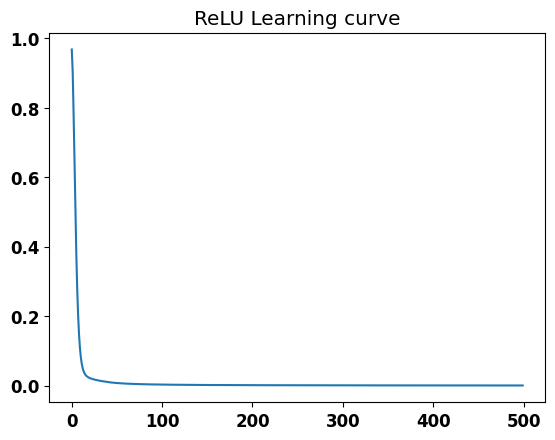

linear MSE: 0.09673469635492256
Experiment Runtime: 11.978008508682251


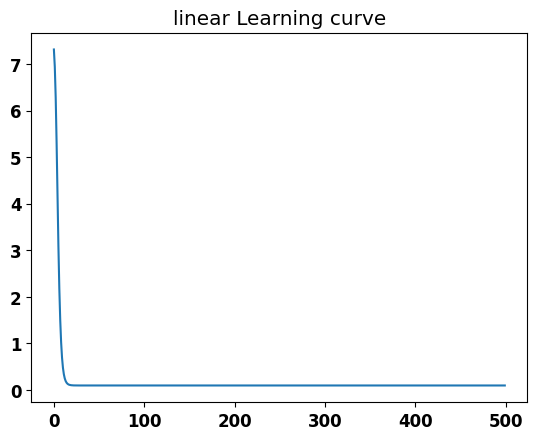

tanh MSE: 0.000991349026287217
Experiment Runtime: 39.716352701187134


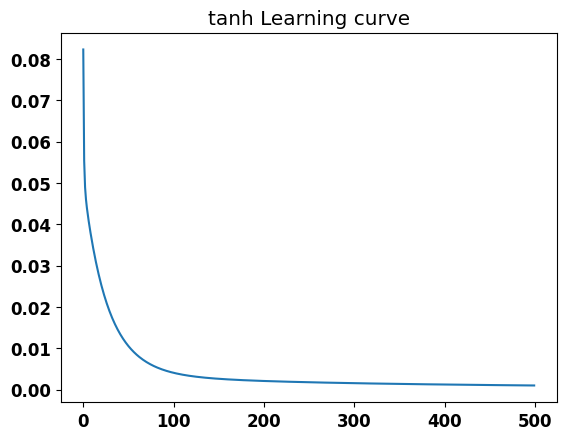

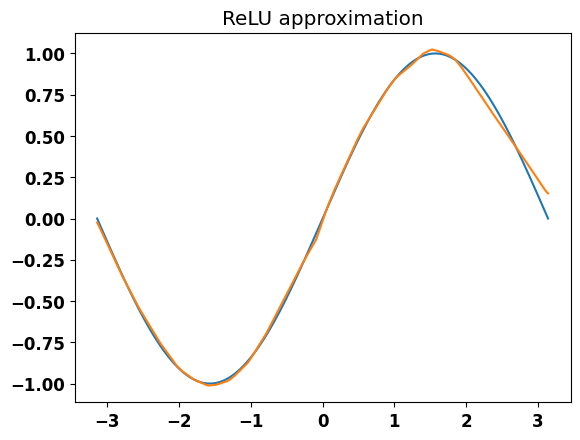

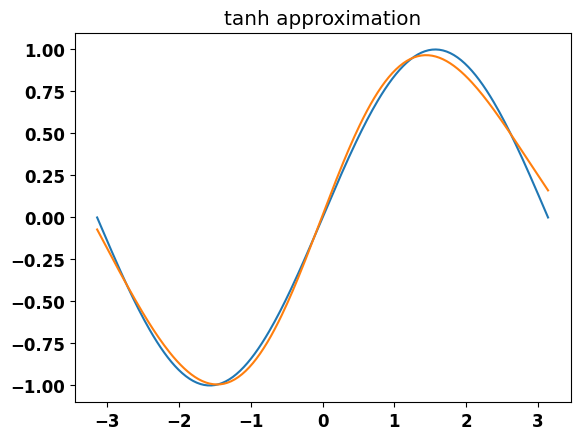

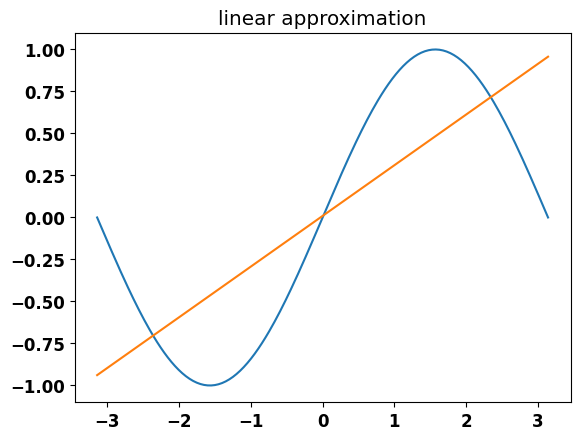

In [ ]:
#### PART G ####
# Generate the training set
np.random.seed(9001)
x = np.random.uniform(-np.pi, np.pi, (1000,1))
y = np.sin(x)
xLin = np.linspace(-np.pi, np.pi, 250).reshape((-1,1))
yHats = {}

activations = dict(ReLU=ReLUActivation,
                    tanh=TanhActivation,
                    linear=LinearActivation)

lr = dict(ReLU=0.02,
          tanh=0.02,
          linear=0.005)

names = ['ReLU','linear','tanh']

if BASE_MODEL:
    print('\n----------------------------------------\n')
    print('Standard fully connected network')
    st = time.time()
    for key in names:
        # Build the model
        activation = activations[key]
        model = Model(x.shape[1])
        model.addLayer(DenseLayer(100,activation()))
        model.addLayer(DenseLayer(100,activation()))
        model.addLayer(DenseLayer(1,LinearActivation()))
        model.initialize(QuadraticCost())

        # Train the model and display the results
        hist = model.train(x, y,
                           500, GDOptimizer(eta=lr[key]))

        yHat = model.predict(x)
        yHats[key] = model.predict(xLin)

        error = np.mean(np.square(yHat - y))/2
        print(key+' MSE: '+str(error))

        se = time.time()
        print(f"Experiment Runtime: {se - st}")

        plt.plot(hist)
        plt.title(key + ' Learning curve')
        plt.show()

    # Plot the approximations
    font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
            'size'   : 12}
    matplotlib.rc('font', **font)

    y = np.sin(xLin)
    for key in activations:
        plt.plot(xLin,y)
        plt.plot(xLin,yHats[key])
        plt.title(key + ' approximation')
        plt.savefig(key + '-approx.png')
        plt.show()




#### ReLU Activation
The ReLU activation showed a consistent decrease in MSE as both the number of nodes and the number of layers increased. Particularly, networks with 50 nodes per layer showed significant improvements in error reduction. For example, the error reduced from `0.04850` with a single layer to `0.00084` with two layers. This suggests that deeper and wider networks are more capable of capturing the complex patterns of the sine function when using ReLU activation.

#### Tanh Activation
Tanh activation presented a different pattern. While there was generally a reduction in error with increased network size, the improvements were not as consistent as with ReLU. For instance, a single-layer network with 25 nodes (`0.00676 MSE`) outperformed a three-layer network with the same number of nodes per layer (`0.00244 MSE`). This indicates that tanh may require careful tuning of network architecture to achieve optimal performance.

### Conclusion
The experiment demonstrates that network architecture significantly influences the performance of neural networks in approximating nonlinear functions. ReLU activation generally benefits from increased size and depth, showing better performance with larger networks. In contrast, tanh activation requires more nuanced adjustments to layers and node counts to optimize performance. The findings highlight the importance of choosing the right network structure and activation function based on the specific characteristics of the function being modeled.








In [ ]:
# Train with different sized networks
#### PART H ####
# Generate the training set
np.random.seed(9001)
x = np.random.uniform(-np.pi, np.pi, (1000,1))
y = np.sin(x)
xLin = np.linspace(-np.pi, np.pi, 250).reshape((-1,1))
yHats = {}

activations = dict(ReLU=ReLUActivation,
                    tanh=TanhActivation,
                    linear=LinearActivation)

lr = dict(ReLU=0.02,
          tanh=0.02,
          linear=0.005)

names = ['ReLU','linear','tanh']

if DIFF_SIZES:
    print('\n----------------------------------------\n')
    print('Training with various sized network')
    st = time.time()

    names = ['ReLU', 'tanh']
    sizes = [5,10,25,50]
    widths = [1,2,3]
    errors = {}
    y = np.sin(x)

    for key in names:
        error = []
        for width in widths:
            for size in sizes:
                activation = activations[key]
                model = Model(x.shape[1])
                for _ in range(width):
                    model.addLayer(DenseLayer(size,activation()))
                model.addLayer(DenseLayer(1,LinearActivation()))
                model.initialize(QuadraticCost())
                hist = model.train(x,y,500,GDOptimizer(eta=lr[key]))
                yHat = model.predict(x)
                yHats[key] = model.predict(xLin)
                e = np.mean(np.square(yHat - y))/2
                error.append(e)
        errors[key] = np.asarray(error).reshape((len(widths),len(sizes)))

    se = time.time()
    print(f"Experiment Runtime: {se - st}")

    # Print the results
    for key in names:
        error = errors[key]
        print(key+' MSE Error')
        header = '{:^8}'
        for _ in range(len(sizes)):
            header += ' {:^8}'
        headerText = ['Layers'] + [str(s)+' nodes' for s in sizes]
        print(header.format(*headerText))
        for width,row in zip(widths,error):
            text = '{:>8}'
            for _ in range(len(row)):
                text += ' {:<8}'
            rowText = [str(width)] + ['{0:.5f}'.format(r) for r in row]
            print(text.format(*rowText))




----------------------------------------

Training with various sized network
Experiment Runtime: 94.86657786369324
ReLU MSE Error
 Layers  5 nodes  10 nodes 25 nodes 50 nodes
       1 0.01457  0.02752  0.00935  0.02050 
       2 0.04289  0.00637  0.00421  0.00235 
       3 0.06549  0.00358  0.00088  0.00047 
tanh MSE Error
 Layers  5 nodes  10 nodes 25 nodes 50 nodes
       1 0.03041  0.01341  0.00441  0.00426 
       2 0.01726  0.00971  0.00406  0.00194 
       3 0.02124  0.00476  0.00247  0.00041 


### OLS + Ridge

After training the neural networks to generate features, a ridge regression model with a regularization parameter of α=0.1 was fit to these features. The performance was measured using the mean squared error (MSE).

#### ReLU Activation
The results with ReLU activation show a trend where increasing both the layer depth and the number of nodes per layer generally leads to better performance, indicated by lower MSE values. Notably, a single-layer network with 50 nodes achieved an MSE of `0.00005`, which demonstrates significant improvement over smaller networks. However, increasing the network size and depth beyond a certain point shows diminishing returns and in some cases, slight increases in error, possibly due to overfitting or instability in the feature extraction.

#### Tanh Activation
For networks using tanh activation, the performance similarly improves with increasing network size. The tanh activation generally achieved better performance compared to ReLU for smaller networks. For example, a single-layer network with 50 nodes reached an MSE of `0.00003`, slightly better than the equivalent ReLU network. The performance across different architectures is more consistent with tanh, suggesting that it might be more robust for feature extraction in this specific setup.

### Conclusion
Both activation functions demonstrated that neural networks could effectively serve as feature extractors for ridge regression, improving the prediction accuracy as network complexity increases. The choice of activation function and the architecture significantly impacts the performance, with tanh showing a slight edge in smaller network configurations. Moreover, using Ridge run much faster than the previous experiment. These insights could guide the design of neural network layers for feature extraction in various regression tasks.








----------------------------------------

Running ridge regression on last layer
Experiment Runtime: 0.12554430961608887
ReLU MSE Error
 Layers  5 nodes  10 nodes 25 nodes 50 nodes
       1 0.00963  0.00470  0.00026  0.00005 
       2 0.01619  0.00059  0.00009  0.00010 
       3 0.12888  0.01415  0.00041  0.00005 
linear MSE Error
 Layers  5 nodes  10 nodes 25 nodes 50 nodes
       1 0.09673  0.09673  0.09673  0.09673 
       2 0.09673  0.09673  0.09673  0.09673 
       3 0.09673  0.09673  0.09673  0.09673 
tanh MSE Error
 Layers  5 nodes  10 nodes 25 nodes 50 nodes
       1 0.00241  0.00131  0.00010  0.00004 
       2 0.01389  0.00070  0.00020  0.00008 
       3 0.02032  0.00886  0.00012  0.00005 


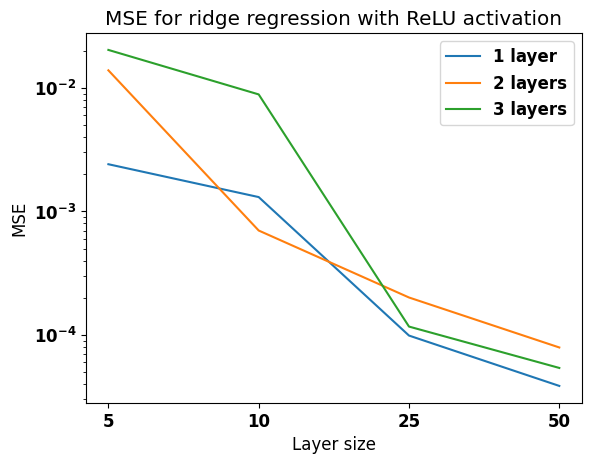

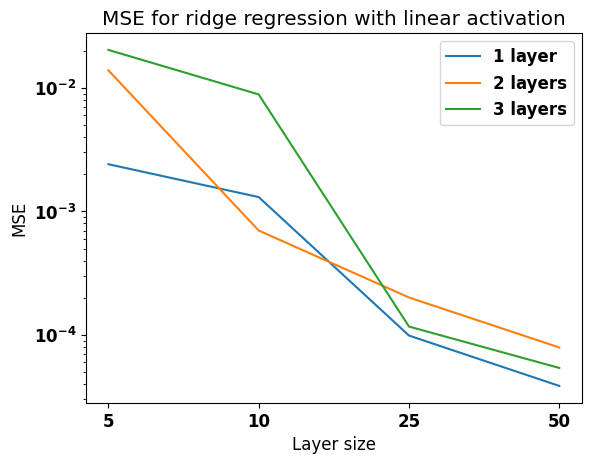

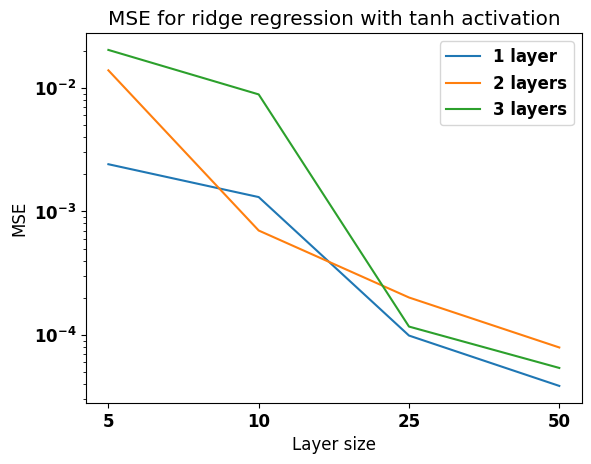

In [ ]:
# Perform ridge regression on the last layer of the network
#### PART I ####
# Generate the training set
np.random.seed(9001)
x = np.random.uniform(-np.pi, np.pi, (1000,1))
y = np.sin(x)
xLin = np.linspace(-np.pi, np.pi, 250).reshape((-1,1))
yHats = {}

activations = dict(ReLU=ReLUActivation,
                    tanh=TanhActivation,
                    linear=LinearActivation)

lr = dict(ReLU=0.02,
          tanh=0.02,
          linear=0.005)

names = ['ReLU','linear','tanh']

if RIDGE:
    print('\n----------------------------------------\n')
    print('Running ridge regression on last layer')
    from sklearn.linear_model import Ridge
    st = time.time()

    errors = {}
    for key in names:
        error = []
        sizes = [5,10,25,50]
        widths = [1,2,3]
        for width in widths:
            for size in sizes:
                activation = activations[key]
                model = Model(x.shape[1])
                for _ in range(width):
                    model.addLayer(DenseLayer(size,activation()))
                model.initialize(QuadraticCost())
                ridge = Ridge(alpha=0.1)
                X = model.predict(x)
                ridge.fit(X,y)
                yHat = ridge.predict(X)
                e = np.mean(np.square(yHat - y))/2
                error.append(e)
        errors[key] = np.asarray(error).reshape((len(widths),len(sizes)))

    se = time.time()
    print(f"Experiment Runtime: {se - st}")

    # Print the results
    for key in names:
        error = errors[key]
        print(key+' MSE Error')
        header = '{:^8}'
        for _ in range(len(sizes)):
            header += ' {:^8}'
        headerText = ['Layers'] + [str(s)+' nodes' for s in sizes]
        print(header.format(*headerText))
        for width,row in zip(widths,error):
            text = '{:>8}'
            for _ in range(len(row)):
                text += ' {:<8}'
            rowText = [str(width)] + ['{0:.5f}'.format(r) for r in row]
            print(text.format(*rowText))

    # Plot the results
    for key in names:
        for width,row in zip(widths,error):
            layer = ' layers'
            if width == 1:
                layer = ' layer'
            plt.semilogy(row,label=str(width)+layer)
        plt.title('MSE for ridge regression with '+key+' activation')
        plt.xticks(range(len(sizes)),sizes)
        plt.xlabel('Layer size')
        plt.ylabel('MSE')
        plt.legend()
        plt.savefig(key+'-ridge.png')
        plt.show()

For the final part of this assignment, I implemented an additional method to the Model() class called sgd_train() to implement the logic for Stochastic Gradient Descent. This function takes in the batch size and all the arguments regular train requires. This first experiment runs the same NN architecture we have been using so far as a default but trained with SGD and vaying the batch size.

The results are quite surprising. This improves the MSE across all choices of activation functions. It also runs significantly faster. Even though I run it for 200 less epochs, the fit was almost perfect except for the linear activation architecture for obvious reasons.


----------------------------------------

Batch Sizes Experimentation
Activation: ReLU
Batch Size: 10, ReLU MSE: 0.00000, Time: 17.58 seconds


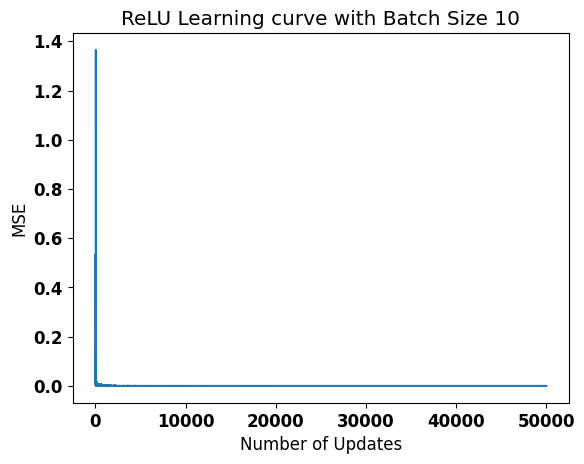

Batch Size: 50, ReLU MSE: 0.00001, Time: 9.36 seconds


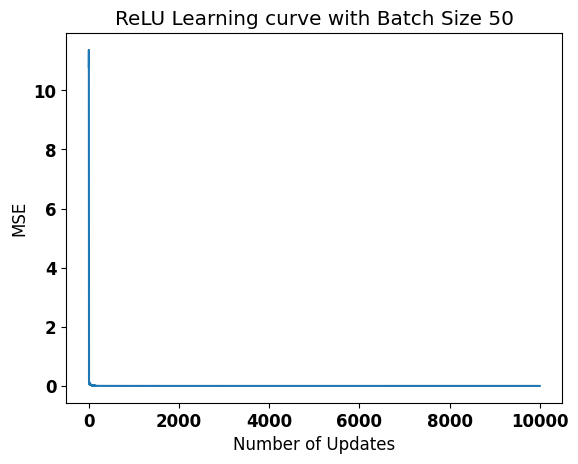

Batch Size: 100, ReLU MSE: 0.00003, Time: 7.86 seconds


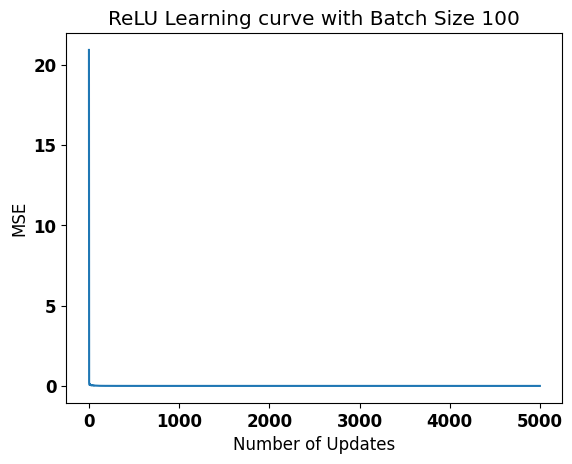

Batch Size: 250, ReLU MSE: 0.00019, Time: 4.79 seconds


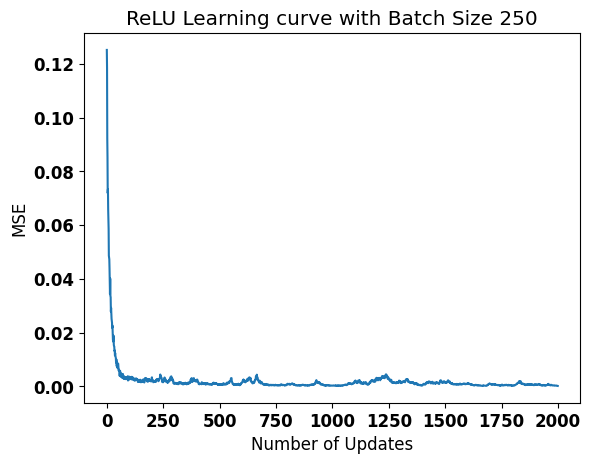

Activation: linear
Batch Size: 10, linear MSE: 0.09751, Time: 16.15 seconds


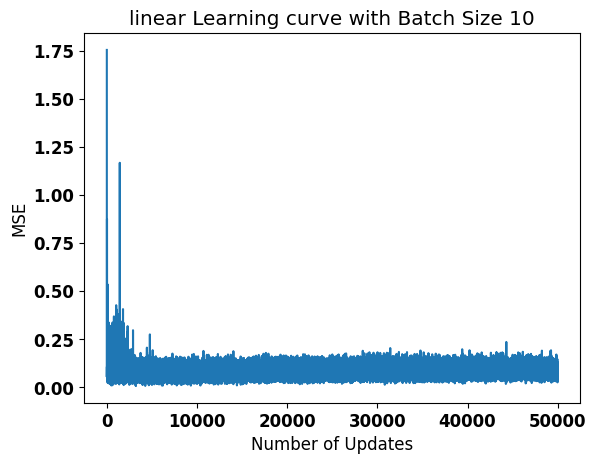

Batch Size: 50, linear MSE: 0.10537, Time: 9.18 seconds


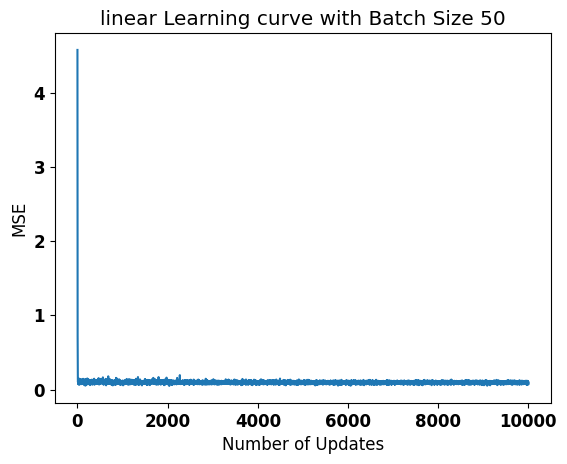

Batch Size: 100, linear MSE: 0.09852, Time: 6.93 seconds


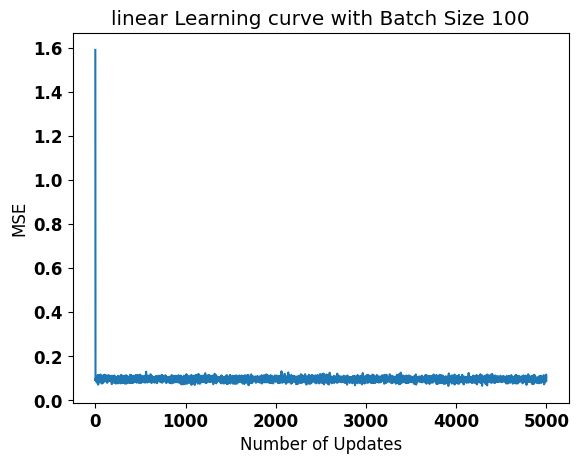

Batch Size: 250, linear MSE: 0.09720, Time: 3.92 seconds


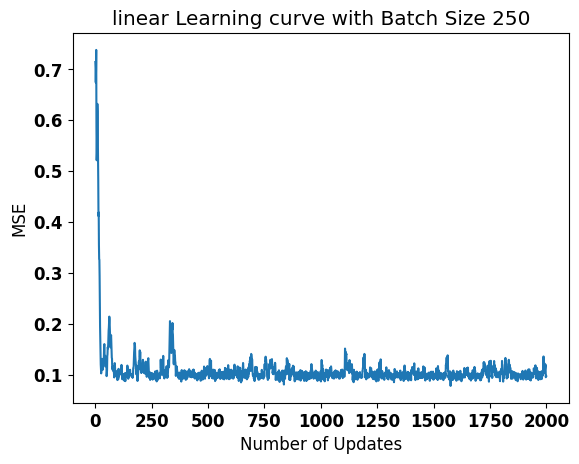

Activation: tanh
Batch Size: 10, tanh MSE: 0.00000, Time: 39.68 seconds


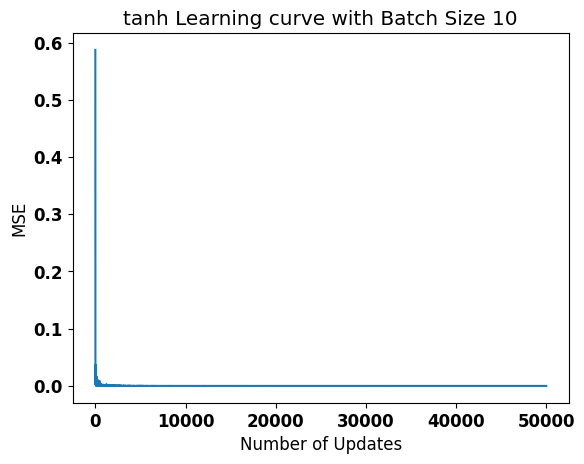

Batch Size: 50, tanh MSE: 0.00000, Time: 37.84 seconds


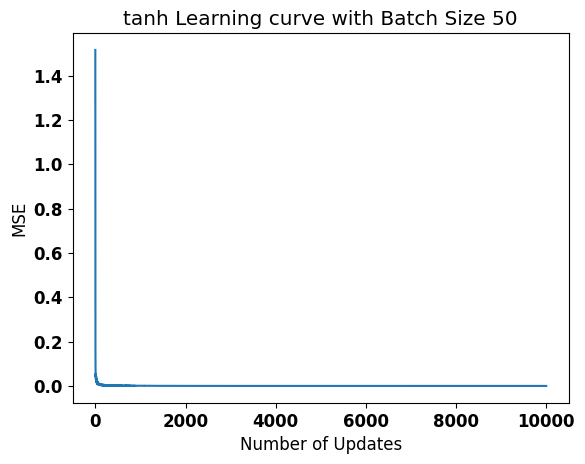

Batch Size: 100, tanh MSE: 0.00003, Time: 36.93 seconds


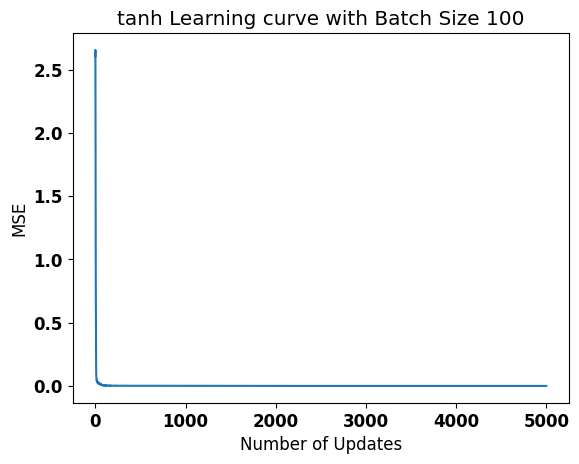

Batch Size: 250, tanh MSE: 0.00006, Time: 30.15 seconds


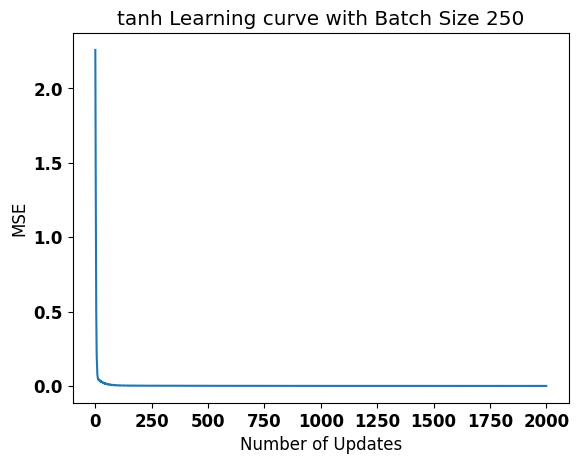

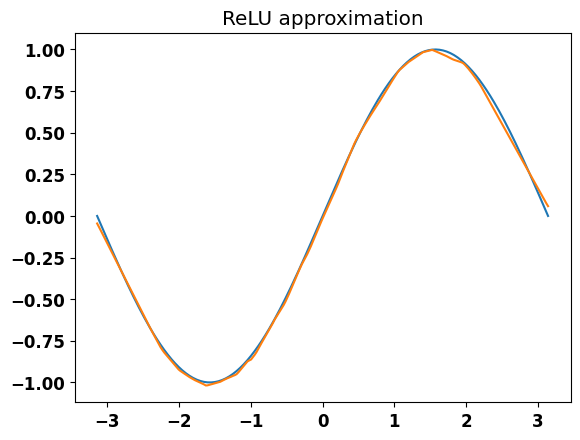

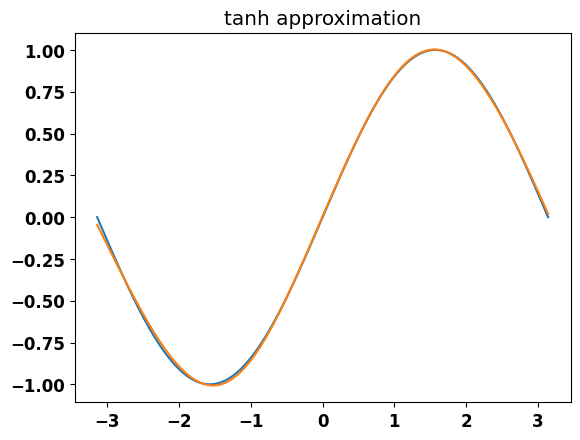

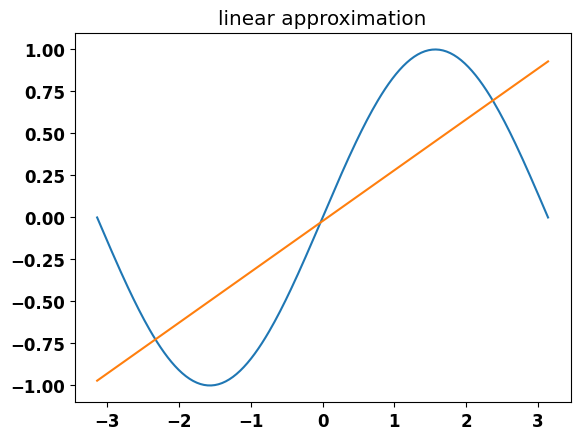

In [ ]:
#### BONUS PART J ####
# Generate the training set
np.random.seed(9001)
x = np.random.uniform(-np.pi, np.pi, (1000,1))
y = np.sin(x)
xLin = np.linspace(-np.pi, np.pi, 250).reshape((-1,1))
yHats = {}

activations = dict(ReLU=ReLUActivation,
                    tanh=TanhActivation,
                    linear=LinearActivation)

lr = dict(ReLU=0.02,
          tanh=0.02,
          linear=0.005)

names = ['ReLU','linear','tanh']

if SGD:
    # Test for SGD... Implement!
    print('\n----------------------------------------\n')
    print('Batch Sizes Experimentation')

    # Batch sizes to test
    batch_sizes = [10, 50, 100, 250]

    for key in names:
        print(f"Activation: {key}")
        for batch_size in batch_sizes:
            st = time.time()

            # Build the model
            activation = activations[key]
            sgd_model = Model(x.shape[1])
            sgd_model.addLayer(DenseLayer(100, activation()))
            sgd_model.addLayer(DenseLayer(100, activation()))
            sgd_model.addLayer(DenseLayer(1, LinearActivation()))
            sgd_model.initialize(QuadraticCost())

            # Train the model with the current batch size
            hist = sgd_model.sgd_train(x, y, batch_size,
                                       500, GDOptimizer(eta=lr[key]))


            yHat = sgd_model.predict(x)
            yHats[key] = sgd_model.predict(xLin)

            error = np.mean(np.square(yHat - y)) / 2
            se = time.time()

            # Print results for current batch size
            print(f"Batch Size: {batch_size}, {key} MSE: {error:.5f}, Time: {se - st:.2f} seconds")

            # Plot learning curve
            plt.plot(hist)
            plt.title(f"{key} Learning curve with Batch Size {batch_size}")
            plt.xlabel('Number of Updates')
            plt.ylabel('MSE')
            plt.savefig(f"{key}-learning_curve-batch_size-{batch_size}.png")
            plt.show()


    # Plot the approximations
    font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
            'size'   : 12}
    matplotlib.rc('font', **font)

    y = np.sin(xLin)
    for key in activations:
        plt.plot(xLin,y)
        plt.plot(xLin,yHats[key])
        plt.title(key + ' approximation')
        plt.savefig(key + '-approx.png')
        plt.show()



In [ ]:
# Generate the training set
np.random.seed(9001)
x = np.random.uniform(-np.pi, np.pi, (1000,1))
y = np.sin(x)
xLin = np.linspace(-np.pi, np.pi, 250).reshape((-1,1))
yHats = {}

activations = dict(ReLU=ReLUActivation,
                    tanh=TanhActivation,
                    linear=LinearActivation)

lr = dict(ReLU=0.02,
          tanh=0.02,
          linear=0.005)

names = ['ReLU','linear','tanh']

print('\n----------------------------------------\n')
print('Learning Rate Experimentation')

# Constant and decreasing learning rates to test
learning_rates = [0.01, 0.05, 0.1]  # Constant rates
decay_rates = [0.5, 1.0]  # Decay rates for adaptive learning

print("\n[Constant Learning rates]")

# Running experiments
for lr in learning_rates:
    st = time.time()

    optimizer = GDOptimizer(eta=lr)  # Constant learning rate
    activation = activations['ReLU']
    const_model = Model(x.shape[1])
    const_model.addLayer(DenseLayer(100, activation()))
    const_model.addLayer(DenseLayer(100, activation()))
    const_model.addLayer(DenseLayer(1, LinearActivation()))
    const_model.initialize(QuadraticCost())

    print(f"Testing constant LR: {lr}")
    hist = const_model.sgd_train(x, y, batchSize=50,
                           numEpochs=300, optimizer=optimizer)

    yHat = const_model.predict(x)

    error = np.mean(np.square(yHat - y)) / 2
    se = time.time()

    # Print results for the current learning rate
    print(f"Learning Rate: {lr}, Final MSE: {error:.5f}, Time: {se - st:.2f} seconds")

# Testing adaptive learning rates
print("\n\n[Adaptive Learning rates]")

for decay_rate in decay_rates:
    initial_lr = 0.1  # Starting learning rate
    optimizer = GDOptimizer(eta=initial_lr)

    activation = activations['ReLU']
    adaptive_model = Model(x.shape[1])
    adaptive_model.addLayer(DenseLayer(100, activation=activation()))  # Add your layers
    adaptive_model.addLayer(DenseLayer(100, activation=activation()))
    adaptive_model.addLayer(DenseLayer(1, activation=LinearActivation()))
    adaptive_model.initialize(QuadraticCost())

    print(f"Testing decreasing LR with decay rate: {decay_rate}")
    hist = adaptive_model.sgd_train(x, y, batchSize=50, numEpochs=100,
                           optimizer=optimizer,
                           adaptive=True, decay_rate=decay_rate)

    yHat = adaptive_model.predict(x)
    error = np.mean(np.square(yHat - y)) / 2
    se = time.time()

    # Print results for the current learning rate
    print(f"Learning Rate: {lr}, Final MSE: {error:.5f}, Time: {se - st:.2f} seconds")



----------------------------------------

Learning Rate Experimentation

[Constant Learning rates]
Testing constant LR: 0.01
Learning Rate: 0.01, Final MSE: 0.00002, Time: 7.52 seconds
Testing constant LR: 0.05
Learning Rate: 0.05, Final MSE: 0.00001, Time: 5.27 seconds
Testing constant LR: 0.1
Learning Rate: 0.1, Final MSE: 0.00001, Time: 6.18 seconds


[Adaptive Learning rates]
Testing decreasing LR with decay rate: 0.5
Learning Rate: 0.1, Final MSE: 0.00987, Time: 8.97 seconds
Testing decreasing LR with decay rate: 1.0
Learning Rate: 0.1, Final MSE: 0.06689, Time: 12.10 seconds


In this particular experiment, we find that keeping the learning rate constant yields much better performance. I believe that adaptive learning might become more practical in real world scenarios where the neural networks are very deep and the structure of the data is well known.